# Quem rende mais: Poupança ou Tesouro Selic?

O objetivo desse estudo é analisar dois investimentos de Renda Fixa do Brasil: a Poupança e o Tesouro Selic. Para tanto, iremos também analisar o efeito da Selic, taxa básica de juros de nosso país, nessas aplicações.

In [1]:
#Importando as bibliotecas necessárias
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

## Importação e Tratamento dos Dados 

In [19]:
#Importação e Visualização dos dados sobre a Selic
df = pd.read_excel('dados_selic_historico.xlsx')
df

,Período de vigência,Meta SELIC,Taxa SELIC
0,08/12/2022 -,13.75,NaN
1,27/10/2022 - 07/12/2022,13.75,13.65
2,22/09/2022 - 26/10/2022,13.75,13.65
3,04/08/2022 - 21/09/2022,13.75,13.65
4,17/06/2022 - 03/08/2022,13.25,13.15
...,...,...,...
254,01/11/1996 - 30/11/1996,1.78,25.27
255,01/10/1996 - 31/10/1996,1.82,23.48
256,01/09/1996 - 30/09/1996,1.88,25.40
257,01/08/1996 - 31/08/1996,1.90,25.01


Período de Vigência: período (entre reuniões do Copom) que foi utilizada o respectivo valor de Selic.<br>
Meta SELIC: meta da Selic definida pelo Copom para aquele período.<br>
Taxa SELIC: Selic de fato praticada. Geralmente, está 0,1 p.p abaixo da Meta SELIC (embora é possível notar que antigamente isso não ocorria. É por esse motivo que só foram considerados dados a partir do ano de 2000, pois a discrepância entre os dois valores é bem menor).

In [3]:
#Periods: lista com os períodos de vigência
periods = df['Período de vigência'].tolist()
periods[0] += " 31/12/2022" #correção do último período (já que não possui data final pois ainda não acabou)

#selic_year_historic: valores da selic (em % a.a), cujo índice corresponde ao período em que foi aplicada
selic_year_historic = df['Taxa SELIC'].tolist()
selic_year_historic[0] = 13.75 #correção do último período (pois só há a Selic Meta, e não a praticada)
#esse valor de 13.75 é igual à Selic Meta do período

In [4]:
#Pegando apenas o período a partir de 2000 (pega o finalzinho de 1999 também)
for index, dates in enumerate(periods):
    dates_text = dates.split(' - ')
    periods[index] = [datetime.strptime(dates_text[0], "%d/%m/%Y"),datetime.strptime(dates_text[1], "%d/%m/%Y")]
    if '1999' in dates:
        periods = periods[:index+1]
        break
periods.reverse() #corrige a ordem; antes estava começando no período atual

#Manipulações necessárias na lista com os valores da Selic para corresponder aos períodos corretos
selic_year_historic = selic_year_historic[:index+1]
selic_year_historic.reverse()

#selic_day_historic: transforma a Selic em % ao ano em % ao dia
selic_day_historic = list(map(lambda x: (1+x/100)**(1/365)-1, selic_year_historic))

## Como a Selic variou ao longo do tempo? 

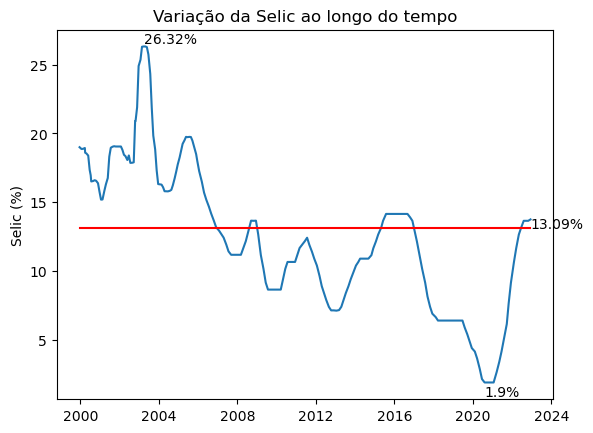

In [5]:
#Gráfico que mostra a variação da Selic ao longo do tempo
dates = [periods[i][0] for i in range(len(periods))]

fig, ax = plt.subplots()
ax.plot(dates, selic_year_historic)

ax.set(ylabel='Selic (%)', title='Variação da Selic ao longo do tempo')

#Valor mínimo
selic_minimum = min(selic_year_historic)
date_selic_minimum = dates[selic_year_historic.index(selic_minimum)]
ax.annotate(str(selic_minimum)+'%', xy=(date_selic_minimum,selic_minimum-1))

#Valor máximo
selic_maximum = max(selic_year_historic)
date_selic_maximum = dates[selic_year_historic.index(selic_maximum)]
ax.annotate(str(selic_maximum)+'%', xy=(date_selic_maximum,selic_maximum+0.2))

#Valor médio
selic_avg = sum(selic_year_historic) / len(selic_year_historic)
selic_avg_list = [selic_avg for _ in (dates)]
ax.plot(dates, selic_avg_list, color='red')
ax.annotate(str(round(selic_avg,2))+'%', xy=(dates[-1],selic_avg))

plt.show()

Pelo gráfico, podemos notar que a taxa variou bastante ao longo dos anos. O valor da Selic é baseado em diversos fatores, mas o principal deles é a inflação, pois a taxa Selic é uma forma de combatê-la. Por isso, em períodos de inflação alta (durante a pandemia do COVID, por exemplo) a Selic tende a aumentar também.<br>
Com base nos dados, temos que a Selic, entre os anos de 2000 e 2022, atingiu o valor mínimo de 1,9% e o valor máximo de 26,32%, sendo sua média de 13,09%.

## Quem rendeu mais: Tesouro Selic ou Poupança?

### Como funciona o rendimento do Tesouro Selic? 

O Tesouro Selic é um título de dívida emitido pelo governo, cuja taxa de juros é a própria Selic (podendo haver um ágio ou deságio, mas este tem um impacto pequeno no valor da taxa). Assim, o rendimento bruto desse investimento é de 100% do valor da Selic. Entretanto, é importante levar em consideração a alíquota de Imposto de Renda (IR), que é aplicada sobre o rendimento e é regressiva (ou seja, quanto maior o período de investimento, menor a alíquota).<br><br>Imposto de Renda Regressivo:
- Até 180 dias: 22,5%
- De 181 até 360 dias: 20%
- De 361 até 720 dias: 17,5%
- A partir de 721 dias: 15%

In [6]:
#Função que calcula o rendimento do Tesouro Selic num certo período
#Parâmetros: valor investido, data inicial, data final
def calculate_Selic(invested_amount, initial_date, final_date): 
    #rate_interest: calcula o rendimento entre duas datas
    rate_interest = lambda initial_date, final_date, rate: (1+rate)**(final_date - initial_date).days
    
    #redemption_value: valor a ser resgatado no final da aplicação
    redemption_value = invested_amount
    
    initial_date = datetime.strptime(initial_date, "%d/%m/%Y")
    final_date = datetime.strptime(final_date, "%d/%m/%Y")

    #Pegar o índice do período que contém a data inicial
    for index, dates in enumerate(periods):
        if dates[0] <= initial_date <= dates[1]:
            break
          
    #Rendimento no período que contém a data inicial
    redemption_value *= rate_interest(initial_date, periods[index][1], selic_day_historic[index])

    #Rendimento nos períodos seguintes. Quando chega no período que contém a data final, o loop é parado
    for rate, dates in zip(selic_day_historic[index+1::], periods[index+1::]):
        if dates[0] <= final_date <= dates[1]:
            redemption_value *= rate_interest(dates[0], final_date, rate)
            break
        redemption_value *= rate_interest(dates[0], dates[1], rate)
        
    #Cálculo da alíquota de Imposto de Renda
    #obs:não é calculado o IOF, pois se supõem que todas as aplicações sejam acima de 30 dias corridos
    invested_time = (final_date - initial_date).days 
    if invested_time <= 180:
        tax_rate = 22.5
    elif invested_time <= 360:
        tax_rate = 20
    elif invested_time <= 720:
        tax_rate = 17.5
    else:
        tax_rate = 15

    #Aplicação do Imposto de Renda
    taxes = (redemption_value - invested_amount)*tax_rate/100
    redemption_value -= taxes
        
    return round(redemption_value,2)

### Como funciona o rendimento da Poupança? 

A poupança é um pouquinho mais complicada de entender. Antes de 02/05/2012, ela tinha uma taxa fixa de 0,5% ao mês + TR, o que dá em torno de 6,17% ao ano. Entretanto, a partir desta data, a regra mudou: agora ela depende do valor da Selic. Se a taxa Selic for menor ou igual a 8,5%, a poupança rende 70% da Selic + TR. Se a Selic for maior que 8,5%, a poupança replica a regra antiga de 0,5% ao mês + TR.<br><br>
A TR é a Taxa Referencial. Ao analisar os dados históricos dela, percebe-se que seu valor tem sido praticamente zero durante a maior parte do período de 2000 a 2022. Por não ter um valor significativo no rendimento da poupança, ela será desconsiderada nesse estudo.<br><br>
Outro detalhe importante sobre a poupança é que ela é isenta de Imposto de Renda, ou seja, não recai alíquota de imposto sobre seu rendimento.

In [7]:
#Função que calcula o rendimento da poupança num certo período
#Parâmetros: valor investido, data inicial, data final
def calculate_Poupanca(invested_amount, initial_date, final_date):
    #rate_interest: calcula o rendimento entre duas datas
    rate_interest = lambda initial_date, final_date, rate: (1+rate)**(final_date - initial_date).days
    
    #redemption_value: valor a ser resgatado no final da aplicação
    redemption_value = invested_amount
    
    initial_date = datetime.strptime(initial_date, "%d/%m/%Y")
    final_date = datetime.strptime(final_date, "%d/%m/%Y")

    #fixed_rate: rendimento de 0,5% a.m transformado em rendimento diário
    fixed_rate = (1+0.5/100)**(1/30) - 1
    #changed_date: data da mudança da regra da poupança
    #obs:foi considerado 31/05/2012 ao invés de 02/05 pois não afetaria o resultado e facilita o script
    change_date = datetime.strptime('31/05/2012', "%d/%m/%Y")
    
    
    #Pegar o índice do período que contém a data inicial
    for index, dates in enumerate(periods):
        if dates[0] <= initial_date <= dates[1]:
            break

    #Rendimento no período que contém a data inicial
    rate = 70/100*selic_day_historic[index] if (((1+selic_day_historic[index])**365 -1)<=8.5/100 and initial_date>change_date) else fixed_rate
    redemption_value *= rate_interest(initial_date, periods[index][1], rate)
    
    #Rendimento nos períodos seguintes. Quando chega no período que contém a data final, o loop é parado
    for selic_day, dates in zip(selic_day_historic[index+1::], periods[index+1::]):
        if dates[0] <= final_date <= dates[1]:
            redemption_value *= rate_interest(dates[0], final_date, rate)
            break
        
        #Caso 1 (após data de mudança e Selic menor ou igual a 8,5% a.a): rende 70% da Selic
        if dates[0] >= change_date and ((1+selic_day)**365 -1)<=8.5/100:
            rate = 70/100*selic_day
        #Caso 2 (antes da data de mudança ou Selic maior que 8,5% a.a): rende 0,5% a.m
        else:
            rate = fixed_rate
            
        redemption_value *= rate_interest(dates[0], dates[1], rate)
    
    return round(redemption_value,2)

### Teste você mesmo! 

In [8]:
#Teste rendimento Tesouro Selic
calculate_Selic(1000, '01/01/2022', '01/05/2022')

1025.71

In [9]:
#Teste rendimento Poupança
calculate_Poupanca(1000, '01/01/2022', '01/05/2022')

1019.81

In [10]:
#Lista com datas de 1 em 1 mês, começando em 01/01/2000 e acabando em 01/12/2022
dates = [datetime.strptime(f'01/{month:02d}/{year}', "%d/%m/%Y") for year in range(2000,2023) for month in range(1,13)]
del dates[0]

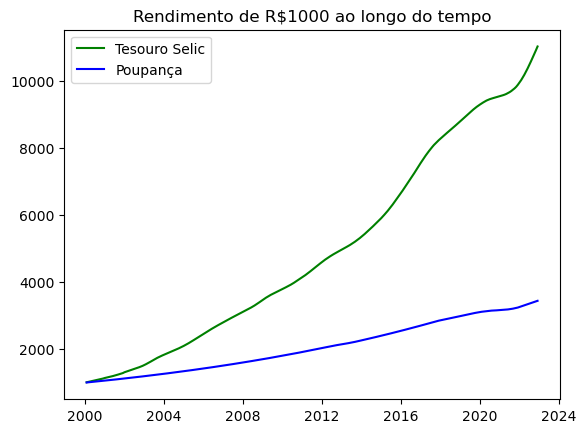

In [11]:
#gráfico desde a criação
fig, ax = plt.subplots()

invested_value = 1000



values_Selic = [calculate_Selic(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y")) for final_date in dates]
values_Poupanca = [calculate_Poupanca(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y")) for final_date in dates]

ax.plot(dates, values_Selic, color='green', label='Tesouro Selic')
ax.plot(dates, values_Poupanca, color='blue', label='Poupança')
plt.legend()

ax.set(title=f'Rendimento de R${invested_value} ao longo do tempo')

plt.show()

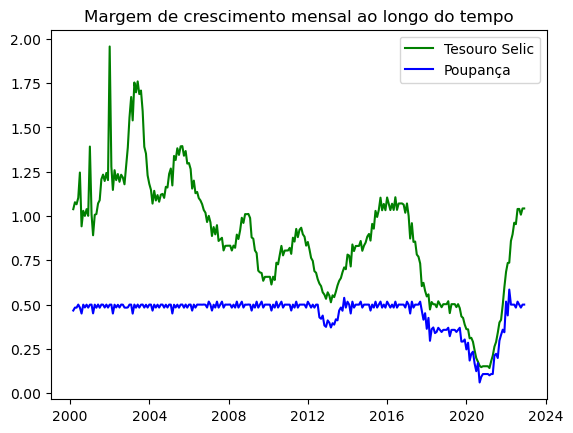

In [12]:
#gráfico do quanto rendeu em cada período (em %)
fig, ax = plt.subplots()

margin_Selic = [100*(values_Selic[i+1] - values_Selic[i])/values_Selic[i] for i in range(len(values_Selic)-1)]
margin_Poupanca = [100*(values_Poupanca[i+1] - values_Poupanca[i])/values_Poupanca[i] for i in range(len(values_Poupanca)-1)]

ax.plot(dates[1::], margin_Selic, color='green', label='Tesouro Selic')
ax.plot(dates[1::], margin_Poupanca, color='blue', label='Poupança')
plt.legend()

ax.set(title='Margem de crescimento mensal ao longo do tempo')

plt.show()

O primeiro gráfico mostra o que aconteceria se investíssimos 1000 reais no Tesouro Selic e na Poupança no dia 01/01/2000 e retirarmos numa certa data. Note que, independente de tirarmos após alguns meses ou após vários anos, o Tesouro Selic sempre rendeu mais que a Poupança.<br><br>
Já o segundo gráfico mostra o crescimento (em %) de cada uma das aplicações nesse período, avaliando de mês em mês. Este mostra a mesma conclusão, uma vez que o crescimento do Tesouro Selic foi sempre superior. O momento em que as duas aplicações mais se aproximaram foi durante um período de Selic baixa, o que pode indicar que, quanto mais baixa a Selic, menor é a discrepância dos dois investimentos (fenômeno que iremos confirmar mais à frente).<br><br>
Mas por quê o Tesouro Selic rendeu tão acima da Poupança? Apesar da Poupança ser isenta de Imposto de Renda, o rendimento dela é muito baixo para compensar esse fato. Se a Selic for menor ou igual a 8,5%, ela rende apenas 70% dela, enquanto o Tesouro Selic rende 100%. E se for acima de 8,5%, a poupança fica fixa em 0,5% ao mês, que é equivalente à 6,17% ao ano, muito abaixo de 8,5% (e se a Selic for muito acima desse valor, a diferença dos dois investimentos é ainda maior).<br><br>
Agora que sabemos que o Tesouro Selic é uma aplicação muito superior à poupança, vamos analisar como diferentes valores de Selic afetam essas aplicações.



## Como a Selic influencia esses rendimentos? 

In [13]:
#Calcula o rendimento do Tesouro Selic entre duas datas e baseado num valor constante de Selic
#Parâmetros: valor investido, data inicial, data final, valor da Selic em %a.a.
def calculate_Selic_v2(invested_amount, initial_date, final_date, Selic):
    #Selic_day: transforma a Selic anual em rendimento diário
    Selic_day = (1+Selic/100)**(1/365)-1
    
    #redemption_value: valor a ser resgatado no final da aplicação
    redemption_value = invested_amount
    
    #invested_time: número de dias totais da aplicação do investimento
    invested_time = (datetime.strptime(final_date, "%d/%m/%Y") - datetime.strptime(initial_date, "%d/%m/%Y")).days
    
    #Cálculo do rendimento total
    redemption_value *= (1+Selic_day)**invested_time
    
    #Cálculo da alíquota de Imposto de Renda
    #obs:não é calculado o IOF, pois se supõem que todas as aplicações sejam acima de 30 dias corridos
    if invested_time <= 180:
        tax_rate = 22.5
    elif invested_time <= 360:
        tax_rate = 20
    elif invested_time <= 720:
        tax_rate = 17.5
    else:
        tax_rate = 15

    #Aplicação do Imposto de Renda
    taxes = (redemption_value - invested_amount)*tax_rate/100
    redemption_value -= taxes
        
    return round(redemption_value,2)

In [14]:
#Calcula o rendimento da Poupança entre duas datas e baseado num valor constante de Selic
#Parâmetros: valor investido, data inicial, data final, valor da Selic em %a.a.
#obs: aqui, se usa apenas a regra nova da poupança. independentemente do período dado
def calculate_Poupanca_v2(invested_amount, initial_date, final_date, Selic):
    #invested_time: número de dias totais da aplicação do investimento
    invested_time = (datetime.strptime(final_date, "%d/%m/%Y") - datetime.strptime(initial_date, "%d/%m/%Y")).days
    
    #Caso 1 (Selic anual menor ou igual a 8.5%): rende 70% da Selic
    if Selic <= 8.5:
        rate = 0.7 * ((1+Selic/100)**(1/365) - 1)
    #Caso 2 (Selic anual maior que 8,5%): rende 0,5% a.m.
    else:
        rate = (1+0.5/100)**(1/30)-1
        
    #Cálculo do rendimento total do investimento
    redemption_value = invested_amount * (1+rate)**invested_time
    
    return round(redemption_value,2)

In [15]:
#gráficos com selics constantes: 1,9%, 13,09% e 26,32%
print(calculate_Selic_v2(1000, '26/03/2002', '26/03/2003', 26.32))

print(calculate_Poupanca_v2(1000, '26/03/2002', '26/03/2003', 26.32))

1217.14
1062.56


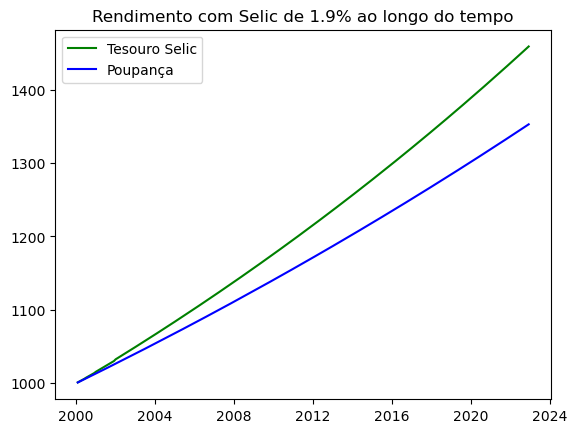

In [16]:
fig, ax = plt.subplots()

values_Selic = [calculate_Selic_v2(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y"), selic_minimum) for final_date in dates]
values_Poupanca = [calculate_Poupanca_v2(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y"), selic_minimum) for final_date in dates]

ax.plot(dates, values_Selic, color='green', label='Tesouro Selic')
ax.plot(dates, values_Poupanca, color='blue', label='Poupança')
plt.legend()

ax.set(title=f'Rendimento com Selic de {selic_minimum}% ao longo do tempo')

plt.show()

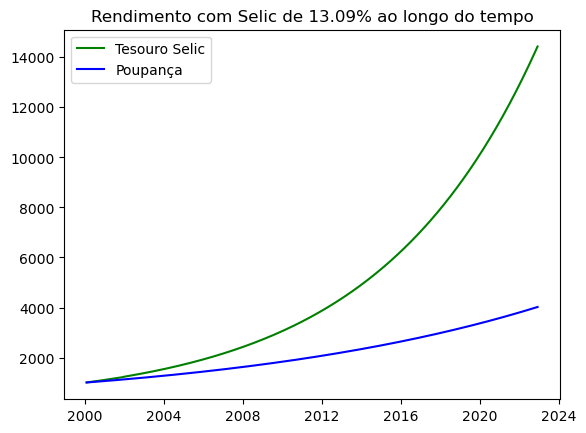

In [17]:
fig, ax = plt.subplots()

values_Selic = [calculate_Selic_v2(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y"), selic_avg) for final_date in dates]
values_Poupanca = [calculate_Poupanca_v2(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y"), selic_avg) for final_date in dates]

ax.plot(dates, values_Selic, color='green', label='Tesouro Selic')
ax.plot(dates, values_Poupanca, color='blue', label='Poupança')
plt.legend()

ax.set(title=f'Rendimento com Selic de {round(selic_avg,2)}% ao longo do tempo')

plt.show()

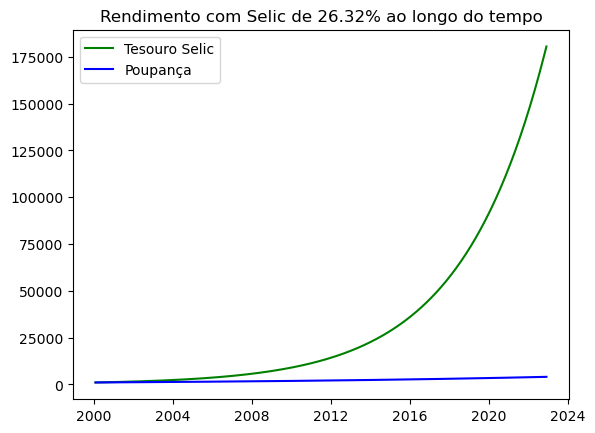

In [18]:
fig, ax = plt.subplots()

values_Selic = [calculate_Selic_v2(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y"), selic_maximum) for final_date in dates]
values_Poupanca = [calculate_Poupanca_v2(invested_value,'01/01/2000',final_date.strftime("%d/%m/%Y"), selic_maximum) for final_date in dates]

ax.plot(dates, values_Selic, color='green', label='Tesouro Selic')
ax.plot(dates, values_Poupanca, color='blue', label='Poupança')
plt.legend()

ax.set(title=f'Rendimento com Selic de {selic_maximum}% ao longo do tempo')

plt.show()

Os três gráficos acima replicam nossa análise anterior, só que agora considerando um valor de taxa Selic constante.<br><br>
No primeiro gráfico, temos uma Selic fixa de 1,9% (valor mínimo entre 2000 e 2022). Apesar da difereça entre o Tesouro Selic e a Poupança não ser tão considerável, o Tesouro Selic continua superando-a em todo o período. É interessante notar que, apesar de o regime ser de juros compostos, as aplicações formam um gráfico praticamente linear, devido à taxa de rendimento ser tão pequena.<br><br>
Já no segundo gráfico, tomamos uma Selic fixada em 13,09% (média histórica). Aqui,temos uma diferença bem mais considerável entre os dois investimentos do que o observado no primeiro gráfico.<br><br>
Por fim, o último gráfico mostra um cenário de Selic fixa em 26,32% (valor máximo atingido entre 2000 e 2022). Aqui, a diferença entre os dois investimentos é tão grande, que a curva da Poupança parece que nem rendeu. Na verdade, ela rendeu sim, mas como seu valor está muito abaixo do Tesouro Selic, nem é possível vê-la. Lembre-se que, enquanto o Tesouro Selic rendeu 26,32% ao ano, a Poupança rendeu apenas 6,17% ao ano.<br><br>
Assim, podemos concluir que, em cenários de Selic baixa, a diferença de rendimento entre o Tesouro Selic e a Poupança não é tão considerável (embora ainda relevante). Já em cenários em que a taxa de juros está alta (principalmente quando acima de 8,5%), a diferença dos dois investimentos é gritante.

## Conclusões 

Independente do jeito que a gente vê, o Tesouro Selic rendeu acima da Poupança, com uma margem bem considerável. Prazos maiores favorecem ainda mais o Tesouro Selic, uma vez que o Imposto de Renda é reduzido e sua taxa de juros é maior que a da Poupança, então o efeito acumulativo dos juros compostos o favorece. Além disso, cenários de Selic alta também favorecem essa diferença, uma vez que a Poupança fica parada no 0,5% ao mês, enquanto o Tesouro Selic vai acompanhando o crescimento da taxa Selic.